# Notebook for preprocessing the LOFAR catalogues before XID+

it outputs a modified LOFAR radio data table with two new columns. the first column is XID+_rerun and is a boolean array stating whether a source should ahve XID+ rerun or not. The second is a string column that says what where the fir for that source comes from.

In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
#from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
#from herschelhelp_internal.utils import inMoc




In [4]:
#Read in the LOFAR data, both optical and radio
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')
#lofar_opt = Table.read('data/edited_cats/optical/LH_MASTER_opt_spitzer_merged_cedit_apcorr.fits')
#lofar_opt.rename_column('ALPHA_J2000','ra')
#lofar_opt.rename_column('DELTA_J2000','dec')

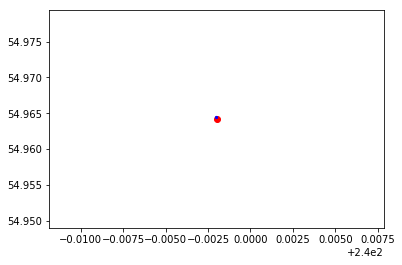

In [32]:
num = 3

x = lofar['RA'][num]
y = lofar['DEC'][num]
plt.scatter(x,y,c='red')

mask = lofar['flag_clean']==1
x = lofar['RA'][mask]
y = lofar['DEC'][mask]
#plt.scatter(x,y,c='green')

x = lofar['optRA'][num]
y = lofar['optDec'][num]
plt.scatter(x,y,c='blue',s=5)

#plt.xlim(242.6,242.64)
#plt.ylim(55.1,55.14)
plt.show()

In [3]:
#Merge the two catalogues 
mask = ~np.isnan(lofar_rad['lr_index_fin'])
lofar = hstack([lofar_rad[mask],lofar_opt[lofar_rad[mask]['lr_index_fin'].astype(int)]])

In [7]:
#Read in the HELP masterlist and select the wanted columns
columns = 'ra','dec','help_id','f_spire_250','ferr_spire_250','flag_spire_250','f_spire_350','ferr_spire_350','flag_spire_350','f_spire_500','ferr_spire_500','flag_spire_500','flag_optnir_det','f_mips_24'
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist = masterlist[columns]

In [10]:
mips_mask = (help_masterlist['flag_optnir_det']>=5) & (help_masterlist['f_mips_24']>20)

prior_cat = help_masterlist[mips_mask]
#xid_rerun = Column(name='XID_rerun',data=np.zeros(len(prior_cat))-99)
#prior_cat.add_column(xid_rerun)

In [13]:
lofar_coords = SkyCoord(lofar['optRA'],lofar['optDec'],unit='deg')
prior_coords = SkyCoord(prior_cat['ra'],prior_cat['dec'],unit='deg')
radius = 2
idx_prior, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    prior_coords, radius*u.arcsec)

In [14]:
not_crossmatched = [i for i in range(len(lofar)) if i not in idx_lofar]

In [15]:
merged_lofar_prior = hstack([lofar[idx_lofar],prior_cat[idx_prior]])

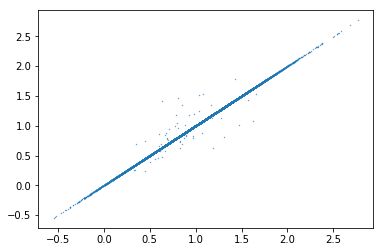

In [18]:
x = np.log10(merged_lofar_prior['f_spire_250']/1000)
y = np.log10(merged_lofar_prior['F_SPIRE_250'])
plt.scatter(x,y,s=0.1)
plt.show()

In [33]:
#merged_lofar_prior.rename_column('ra_1','ra')
#merged_lofar_prior.rename_column('dec_1','dec')
merged_lofar_prior = vstack([merged_lofar_prior,lofar[not_crossmatched]])

In [34]:
rerun_col = Column(data=merged_lofar_prior['f_spire_250'].mask,name='xid+_rerun',dtype=bool)
merged_lofar_prior.add_column(rerun_col)

In [61]:
lofar_coords = SkyCoord(merged_lofar_prior['ra'],merged_lofar_prior['dec'],unit='deg')
prior_coords = SkyCoord(prior_cat['ra'],prior_cat['dec'],unit='deg')
radius = 2
idx_prior, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    prior_coords, radius*u.arcsec)

In [36]:
uniq_ids_prior,counts_prior = np.unique(idx_lofar,return_counts=True)
source_type = np.zeros(len(merged_lofar_prior))
source_type[uniq_ids_prior] = counts_prior

In [74]:
np.min(d2d[idx_lofar==3]).value
d2d[idx_lofar==3]
np.max(d2d.value*3600)

1.9734551950306278

In [37]:
#there may be a problem here NEEDS TO BE DOUBLE CHECKED
min_d2d_prior_val = [np.min(d2d[idx_lofar==i].value) for i in uniq_ids_prior]
min_d2d_prior = np.ones(len(merged_lofar_prior))
min_d2d_prior[uniq_ids_prior] = min_d2d_prior_val

In [40]:
lofar_coords = SkyCoord(merged_lofar_prior['ra'],merged_lofar_prior['dec'],unit='deg')
help_coords = SkyCoord(help_masterlist['ra'],help_masterlist['dec'],unit='deg')
radius = 2
idx_help, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    help_coords, radius*u.arcsec)

In [41]:
uniq_ids_help,counts_help = np.unique(idx_lofar,return_counts=True)
source_type_help = np.zeros(len(merged_lofar_prior))
source_type_help[uniq_ids_help] = counts_help

In [42]:
min_d2d_help_val = [np.min(d2d[idx_lofar==i].value) for i in uniq_ids_help]
min_d2d_help = np.ones(len(merged_lofar_prior))
min_d2d_help[uniq_ids_help] = min_d2d_help_val

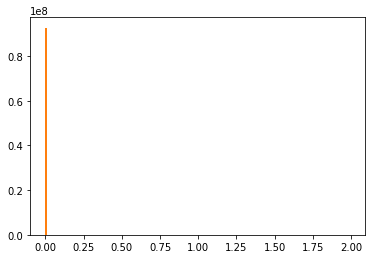

In [59]:
bins = np.arange(0,2,0.01)
plt.hist(min_d2d_help_val*3600,bins=bins)
plt.hist(min_d2d_prior_val*3600,bins=bins)
plt.show()

In [58]:
min_d2d_help_val

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [258]:
source_class = np.where((min_d2d_help<min_d2d_prior),'nearer_non_prior','nearest_prior')
source_class = np.where((min_d2d_help==min_d2d_prior),'no nearby sources',source_class)
#source_class = np.array(['nearest_prior' for i in range(len(merged_lofar_prior))])
source_class = np.where(source_type==0,'radio_position',source_class)
source_class = np.where(source_type>1,'multiple_prior',source_class)

source_class = source_class.astype('U42')

mask = (source_type>0) & (min_d2d_help>min_d2d_prior)
for i,source in enumerate(source_class):
    if mask[i]==True:

        source_class[i] = source_class[i] + '_with_nearer_non_prior'


In [262]:
class_col = Column(data=source_class,name='prior_type')
merged_lofar_prior.add_column(class_col)

In [267]:
colnames_keep = ['Source_id',
 'Isl_id',
 'RA',
 'E_RA',
 'DEC',
 'E_DEC',
 'Total_flux',
 'E_Total_flux',
 'Peak_flux',
 'E_Peak_flux',
 'RA_max',
 'E_RA_max',
 'DEC_max',
 'E_DEC_max',
 'Maj',
 'E_Maj',
 'Min',
 'E_Min',
 'PA',
 'E_PA',
 'Maj_img_plane',
 'E_Maj_img_plane',
 'Min_img_plane',
 'E_Min_img_plane',
 'PA_img_plane',
 'E_PA_img_plane',
 'DC_Maj',
 'E_DC_Maj',
 'DC_Min',
 'E_DC_Min',
 'DC_PA',
 'E_DC_PA',
 'DC_Maj_img_plane',
 'E_DC_Maj_img_plane',
 'DC_Min_img_plane',
 'E_DC_Min_img_plane',
 'DC_PA_img_plane',
 'E_DC_PA_img_plane',
 'Isl_Total_flux',
 'E_Isl_Total_flux',
 'Isl_rms',
 'Isl_mean',
 'Resid_Isl_rms',
 'Resid_Isl_mean',
 'S_Code',
 'FLAG_OVERLAP_1',
 'flag_clean_1',
 'Source_Name',
 'lr_fin',
 'lr_dist_fin',
 'lr_index_fin',
 'ra',
 'dec',
 'ra_2',
 'dec_2',
 'help_id',
 'f_spire_250',
 'ferr_spire_250',
 'flag_spire_250',
 'f_spire_350',
 'ferr_spire_350',
 'flag_spire_350',
 'f_spire_500',
 'ferr_spire_500',
 'flag_spire_500',
 'flag_optnir_det',
 'f_mips_24',
 'bayes.dust.luminosity',
 'bayes.dust.luminosity_err',
 'best.universe.redshift',
 'xid+_rerun',
 'prior_type']

In [268]:
merged_lofar_prior = merged_lofar_prior[colnames_keep]

In [269]:
Table.write(merged_lofar_prior,'data/xid+_prepared_cat.fits')